<a href="https://colab.research.google.com/github/probabll/mixed-rv-vae/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


On Colab, you will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [62]:
import torch
torch.__version__

'1.8.1+cu102'

In [63]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [64]:
from collections import namedtuple, OrderedDict, defaultdict
from tqdm.auto import tqdm
from itertools import chain
from tabulate import tabulate

In [65]:
from components import GenerativeModel, InferenceModel, VAE
from data import load_mnist
from main import load_cfg, make_args, make_state, get_batcher, validate

In [66]:
from analysis import compare_marginals, compare_samples

# Load model and data

* Load hyperparameters
* Load model state
* Load MNIST data

In [70]:
directory = 'neurips-mixed-rv/IvI/sage-haze-105'
args = make_args(
    load_cfg(
        f"{directory}/cfg.json", 
        # use this to specify a decide for analysis
        device='cuda:1',
        # use this to change paths if you need
        data_dir='./tmp',
        # you don't really need to change the output_dir
    )
)
args

Setting tqdm to default False
Overriding device to user choice cuda:1
Overriding data_dir to user choice ./tmp


Config(seed=10, batch_size=200, data_dir='./tmp', height=28, width=28, output_dir='/ssdstore/vnicula/neurips-mixed-rv/IvI/mixed-vae/sage-haze-105', device='cuda:1', y_dim=10, prior_f='gibbs-max-ent 0', prior_y='dirichlet 1.0', z_dim=0, hidden_dec_size=500, posterior_f='gibbs -10 10', posterior_y='dirichlet 1e-3 1e3', shared_concentrations=True, mean_field=True, hidden_enc_size=500, epochs=500, num_samples=100, gen_opt='adam', gen_lr=0.001, gen_l2=0.0, gen_p_drop=0.0, inf_opt='adam', inf_lr=0.0005, inf_l2=1e-06, inf_p_drop=0.1, grad_clip=5.0, training_samples=1, exact_marginal=False, use_self_critic=True, use_reward_standardisation=False, wandb=False, wandb_watch=False, prior_z='gaussian 0.0 1.0', posterior_z='gaussian', load_ckpt=False, reset_opt=False, tqdm=False)

In [71]:
state = make_state(
    args, 
    device=args.device, 
    # change this to .best if you want the best ckpt (rather than the last)
    ckpt_path=f"{directory}/ckpt.last"
)

In [72]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to=args.data_dir, 
    height=args.height, 
    width=args.width
)

In [73]:
val_metrics = validate(state.vae, get_batcher(valid_loader, args), args.num_samples)
print(f'Saved ckpt - Validation: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

Saved ckpt - Validation: nll=105.32 bpd=15.19


# Training Curves

In [74]:
np_stats_tr = {k: np.array(v) for k, v in state.stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in state.stats_val.items()}

In [75]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

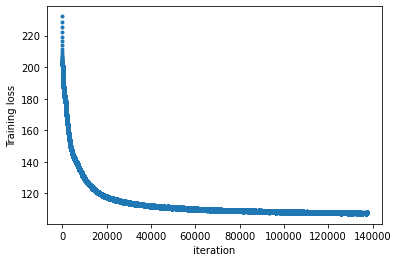

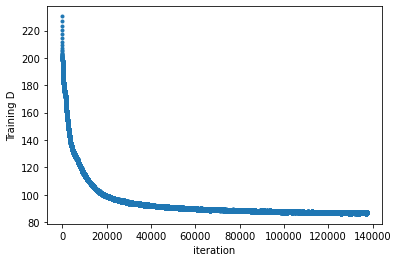

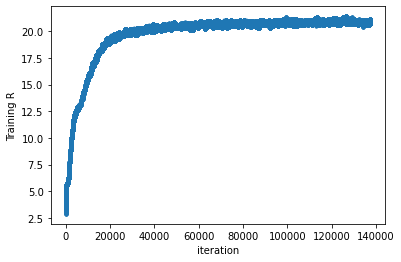

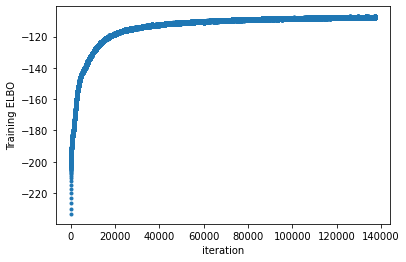

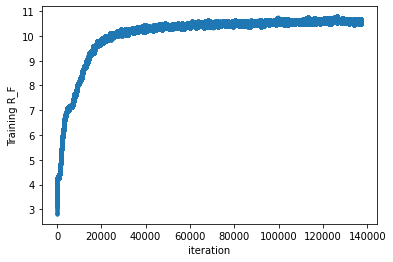

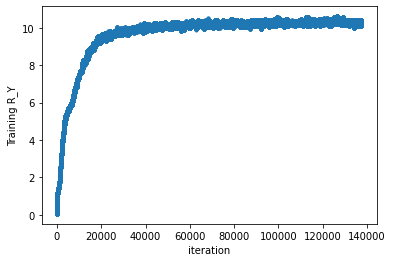

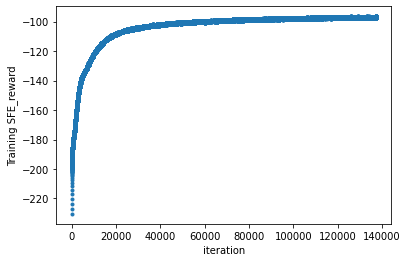

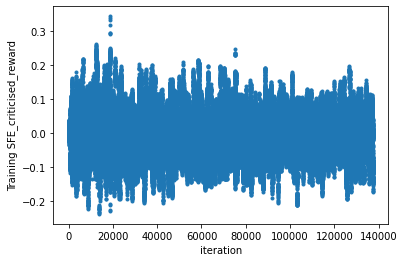

In [76]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

# Validation Curves

In [77]:
print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric         mean         min
--------  ---------  ----------
val_nll    105.604    105.288
val_bpd     15.2354    15.1898
val_ELBO  -108.853   -109.265
val_D       88.0616    87.5545
val_R       20.7918    20.4324
val_R_F     10.5652    10.433
val_R_Y     10.2266     9.99939


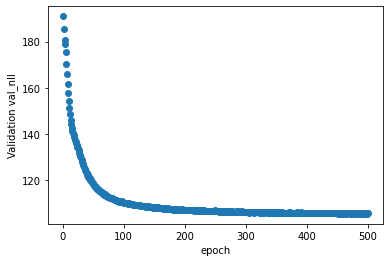

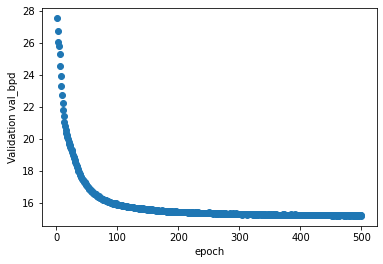

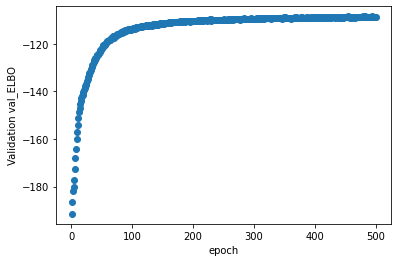

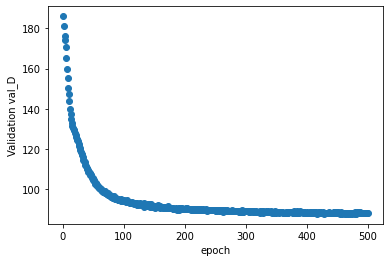

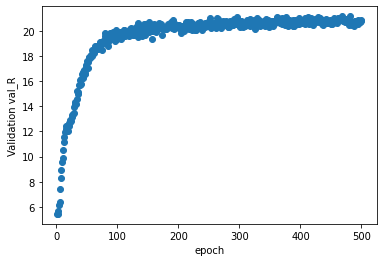

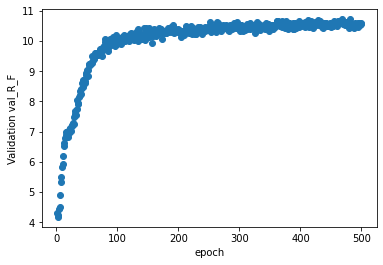

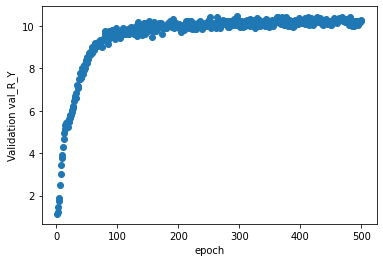

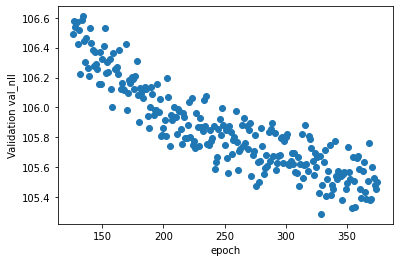

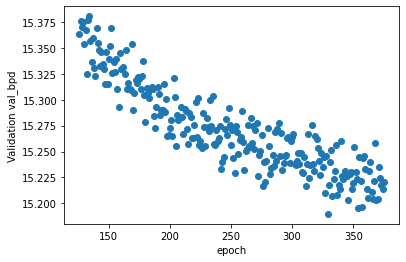

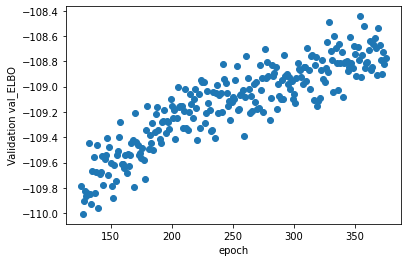

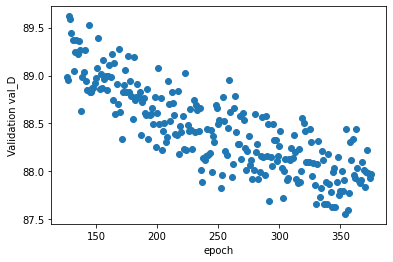

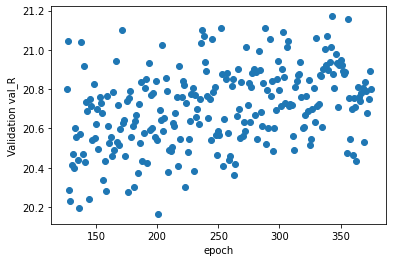

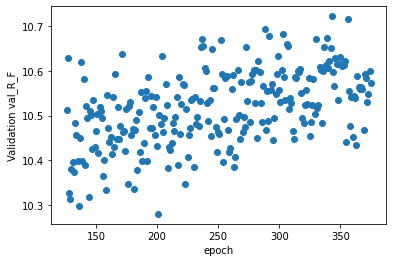

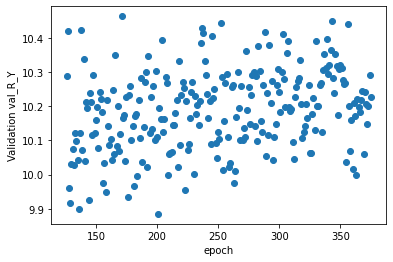

In [78]:
for k, v in np_stats_val.items():
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()
for k, v in np_stats_val.items():
    v = v[v.size//2:]
    plt.plot(np.arange(1 + v.size//2, v.size + 1 + v.size//2), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()    

In [79]:
val_nll, val_bpd, val_DR = validate(
    state.vae, get_batcher(valid_loader, args), args.num_samples, compute_DR=True)

In [80]:
rows = [('IS-NLL', val_nll, None), ('IS-BPD', val_bpd, None)]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric         mean       std
--------  ---------  --------
IS-NLL     105.436
IS-BPD      15.2113
ELBO      -108.631   32.9281
D           87.8428  29.6323
R           20.7886   5.67676
R_F         10.5721   2.31996
R_Y         10.2164   3.44748


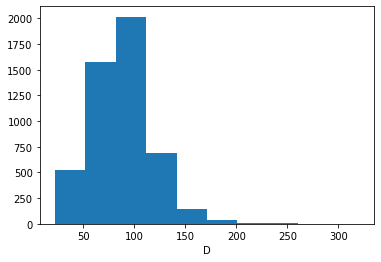

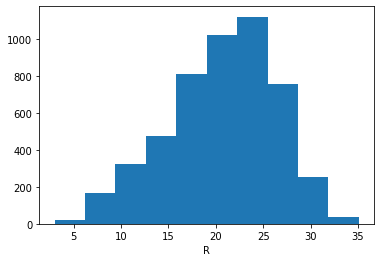

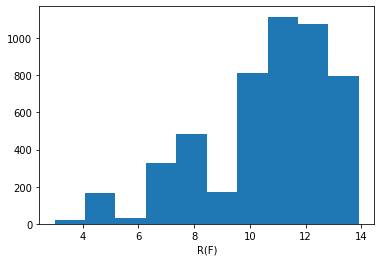

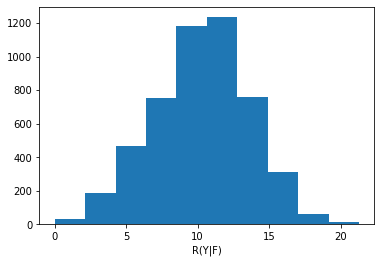

In [81]:
_ = plt.hist(val_DR['D'])
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'])
_ = plt.xlabel('R')
plt.show()

if state.vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'])
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if state.vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'])
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y'])
    _ = plt.xlabel('R(Y|F)')
    plt.show()

# Analysis

## KL

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


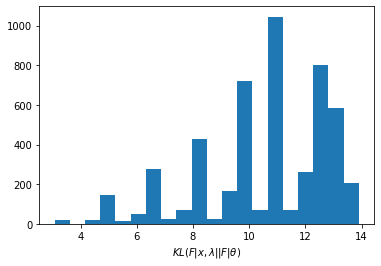

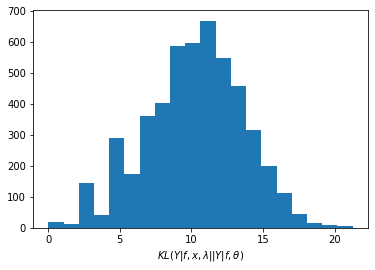

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


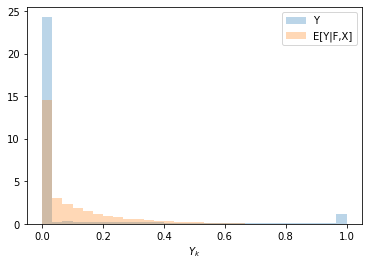

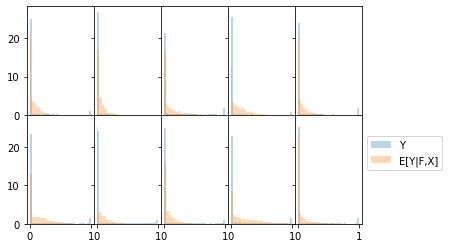

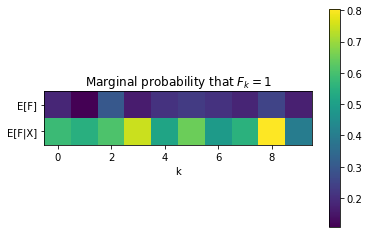

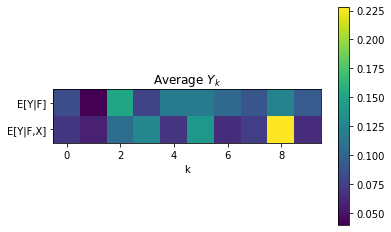

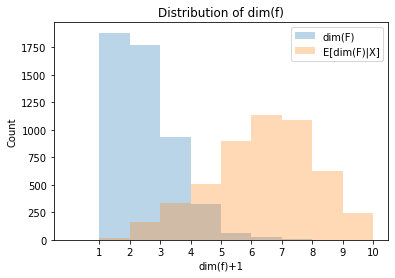

In [82]:
compare_marginals(state.vae, get_batcher(valid_loader, args), args, cols=5)

## Posterior and Prior Samples

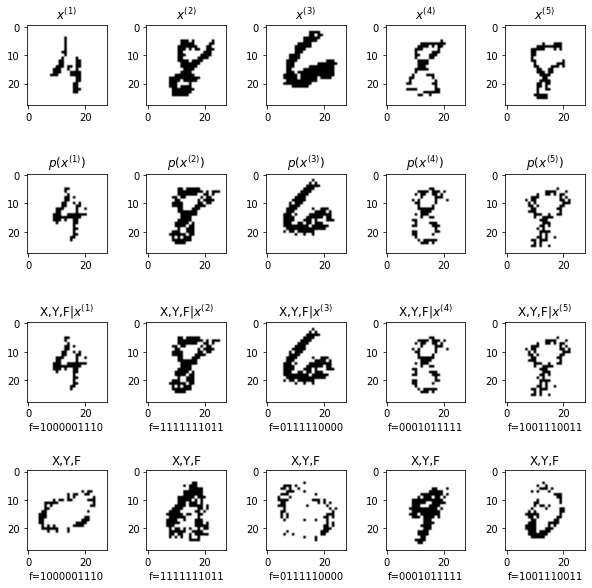

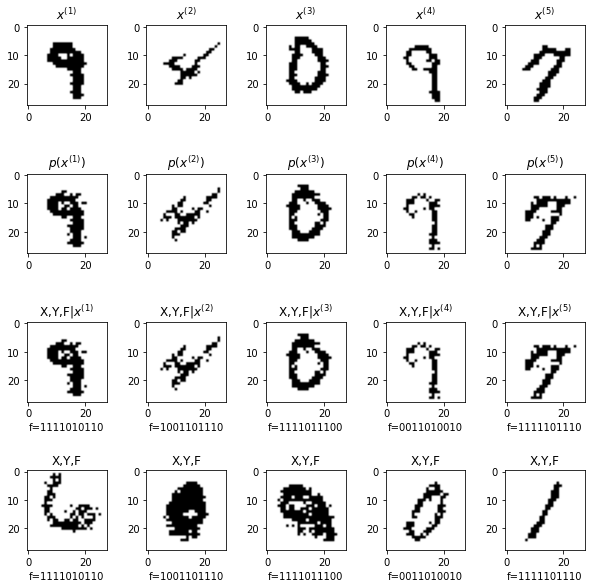

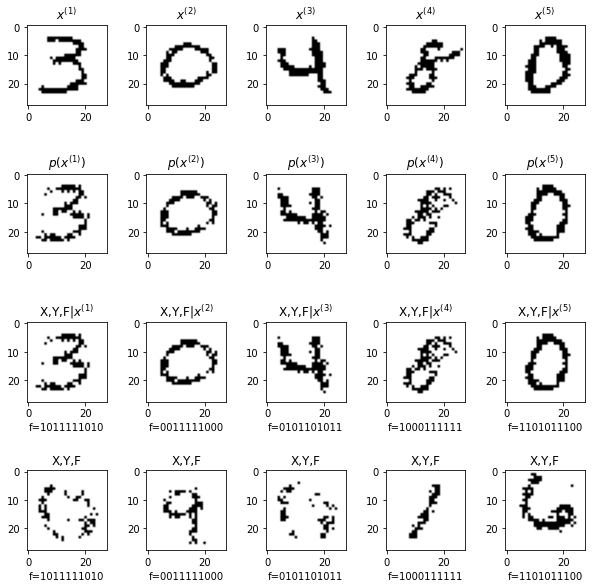

In [83]:
compare_samples(state.vae, get_batcher(valid_loader, args), args, N=5, num_figs=3)

## TSNE

In [49]:
from analysis import samples_per_digit

In [50]:
f, y, z, x = samples_per_digit(state.vae, get_batcher(valid_loader, args, onehot=False), args)

In [51]:
f.shape, f.mean(1).shape, z.shape, z.mean(1).shape, x.shape, x.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 0), (10, 0), (10, 458, 784), (10, 784))

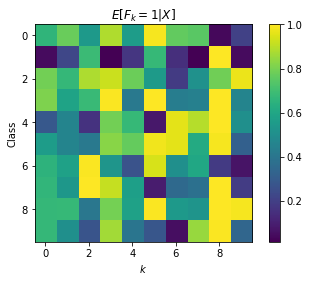

In [52]:
if state.vae.p.y_dim:
    _ = plt.imshow(f.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[F_k = 1|X]$')
    _ = plt.colorbar()

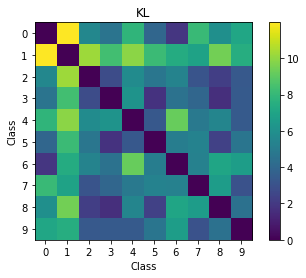

In [53]:
from itertools import product

if state.vae.p.y_dim:
    marginal_f = f.mean(1)
    Fs = [td.Independent(td.Bernoulli(probs=(torch.tensor(marginal_f[c])*0.99 + 1e-4)), 1) for c in range(10)]
    JS_F = np.array([[(0.5*td.kl_divergence(Fs[c], Fs[c_])+0.5*td.kl_divergence(Fs[c_], Fs[c])).numpy() for c_ in range(10)] for c in range(10)])
    #KL_F = np.array([[td.kl_divergence(Fs[c], Fs[c_]).numpy() for c_ in range(10)] for c in range(10)])
    _ = plt.imshow(JS_F)
    _ = plt.ylabel('Class')
    _ = plt.yticks(np.arange(10), np.arange(10))
    _ = plt.xlabel('Class')
    _ = plt.xticks(np.arange(10), np.arange(10))
    _ = plt.title(r'KL')
    _ = plt.colorbar()

In [54]:
from sklearn.manifold import TSNE

In [55]:
def tsne_plot(samples, title):
    """
    :param samples: [10, N,D]
    """
    assert samples.shape[0] == 10, "I need 10 digits"
    D = samples.shape[-1]
    assert D > 0, "0-dimensional features?"
    tsne_results = TSNE(n_components=2, random_state=1).fit_transform(samples.reshape(-1, D)).reshape(10, -1, 2)
    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple'
    for i, c in zip(np.arange(10), colors):
        plt.scatter(tsne_results[i, :, 0], tsne_results[i, :, 1], c=c, label=i)
    plt.legend(bbox_to_anchor=(1, 0.85), loc='upper left')
    plt.title(title)
    plt.show()
    return tsne_results

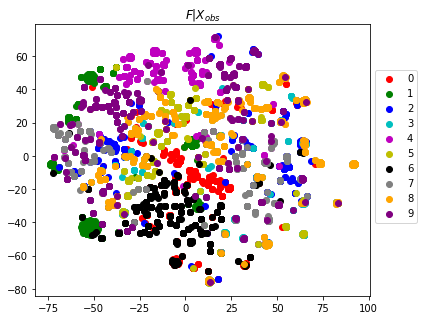

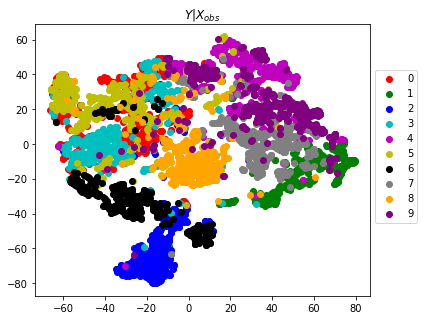

In [56]:
if state.vae.p.y_dim:
    _ = tsne_plot(f, r"$F|X_{obs}$")
    _ = tsne_plot(y, r"$Y|X_{obs}$")

In [59]:
if state.vae.p.z_dim:
    _ = tsne_plot(z, r"$Z|X_{obs}$")

## Marginal samples per class

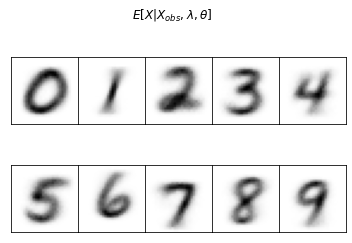

In [60]:
marginal_x = x.mean(1)
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(marginal_x[c].reshape(args.height, args.width), cmap='Greys')
    #axs[c // 5, c % 5].set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
_ = fig.suptitle(r'$E[X|X_{obs}, \lambda, \theta]$')    